# XDGMM Demo

In this notebook we demonstrate some of the funcitonality of the XDGMM class.

First, import necessary packages. This demo will borrow from the AstroML XD demo [here](http://www.astroml.org/book_figures/chapter6/fig_XD_example.html#book-fig-chapter6-fig-xd-example).

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from xdgmm import XDGMM

from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import ShuffleSplit

from astroML.plotting.tools import draw_ellipse
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

Next, generate some data to use for our fitting and plotting. This generates the same dataset as in the AstroML demo.

In [3]:
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

## Validation Curve

We could fit this data directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. One benefit of the XDGMM class is that it is compatible with the scikit-learn cross-validation methods, so we can use this to test the performance of the model with different numbers of components and produce a validation curve to determine the ideal number to use.

This code will test the performance of the model with n_components ranging from 1 to 12 and produce a validation curve figure. 

Note the "trick" used to pass errors to the scikit-learn mdethods. Normally for unsupervised learning you would only pass an X array, and not a "target" y array to the validation_curve method. However, we need to pass an error array to our xdgmm.fit method, and validation_curve simply uses the y parameter as the second argument for the fit function. So, by treating the Xerr array as the "target" array, we can pass it to our fit function to fit the data properly.

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   59.3s finished


[-6050.54834026 -6050.54834026 -6050.54834026 -6050.54834026 -6050.54834026
 -6050.54834026 -6050.54834026 -6050.54834026 -6050.54834026 -6050.54834026
 -6050.54834026 -6050.54834026] [-2589.32206912 -2589.32206912 -2589.32206912 -2589.32206912 -2589.32206912
 -2589.32206912 -2589.32206912 -2589.32206912 -2589.32206912 -2589.32206912
 -2589.32206912 -2589.32206912]


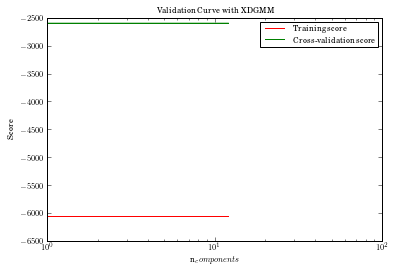

In [10]:
xdgmm=XDGMM()

param_range=[1,2,3,4,5,6,7,8,9,10,11,12]
shuffle_split = ShuffleSplit(len(X), 3, test_size=0.3, random_state=0)

train_scores,test_scores=validation_curve(xdgmm,X=X,y=Xerr,param_name="n_components",param_range=param_range,n_jobs=3,cv=shuffle_split,verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print train_scores_mean, test_scores_mean

plt.title("Validation Curve with XDGMM")
plt.xlabel("n_components")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()